# **Menangani Imbalance Ecoli dengan ADASYN**
Dokumentasi ini merangkum proyek saya dalam menangani masalah data tidak seimbang (imbalanced data) menggunakan dataset Ecoli.

**Latar Belakang Masalah:** \
Kenapa Data Tidak Seimbang Itu Masalah?
Dalam banyak kasus dunia nyata, data yang kita kumpulkan seringkali tidak seimbang. Artinya, jumlah data untuk satu kategori (kelas mayoritas) jauh lebih banyak daripada kategori lainnya (kelas minoritas). Jika kita biarkan, model machine learning yang dilatih pada data seperti ini akan cenderung "malas". Ia akan menjadi sangat pandai mengenali kelas mayoritas tetapi sangat buruk dalam mengenali kelas minoritas yang seringkali justru lebih penting. Akibatnya, metrik seperti akurasi bisa sangat tinggi dan menipu, padahal performa model pada kasus-kasus penting sebenarnya sangat rendah.

**Tujuan Proyek**

Tujuan dari proyek ini adalah untuk menerapkan dan membandingkan dua teknik oversampling yang populer, yaitu SMOTE dan ADASYN. Saya ingin melihat bagaimana cara kerja masing-masing metode dan apa perbedaan hasil akhirnya, baik secara kuantitatif maupun visual, pada dataset Ecoli.

**Tahapan yang saya lakukan:**

1. Menganalisis distribusi kelas data Ecoli untuk mengidentifikasi masalah ketidakseimbangan.
2. Memvisualisasikan data asli dengan PCA untuk mendapatkan bukti visual dari masalah tersebut.
3. Menerapkan SMOTE sebagai metode penyeimbangan dasar dan menganalisis hasilnya.
4. Menerapkan ADASYN, termasuk mengatasi batasan teknisnya dengan pendekatan pipeline.
5. Membandingkan hasil kuantitatif dari SMOTE dan ADASYN menggunakan tabel.
6. Membuat visualisasi perbandingan akhir dengan PCA untuk menunjukkan perbedaan dampak dari kedua metode, serta menandai data hasil generate.

**Langkah 1: Memahami Kondisi Awal Data**

Sebelum melakukan apa pun, saya perlu tahu dulu kondisi data Ecoli yang saya gunakan. Setelah memuat data dari database, saya langsung memeriksa distribusi kelasnya.


```python
# Impor library yang dibutuhkan
import pandas as pd
import mysql.connector
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

# LANGKAH 1: KONEKSI KE DATABASE MYSQL
print("--- LANGKAH 1: Menghubungkan ke Database ---")
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'pertemuan5'
}
table_name = 'ecoli'
try:
    conn = mysql.connector.connect(**db_config)
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, conn)
    conn.close()
    print(f"✅ Koneksi berhasil! {len(df)} baris data dari tabel '{table_name}' telah dimuat.")

except mysql.connector.Error as e:
    print(f"❌ Error saat koneksi ke MySQL: {e}")
    exit()


# LANGKAH 2: ANALISIS & PERSIAPAN DATA
print("\n--- LANGKAH 2: Menganalisis dan Mempersiapkan Data ---")
feature_columns = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
target_column = 'localization_class'

X = df[feature_columns]
y = df[target_column]
print("\n[INFO] Ringkasan struktur data:")
X.info()

print("\n[ANALISIS] Distribusi kelas sebelum penyeimbangan:")
print("Ini menunjukkan adanya ketidakseimbangan (imbalance) yang signifikan.")
class_counts_before = y.value_counts()
print(class_counts_before)
```


**Distribusi Kelas Data Asli**

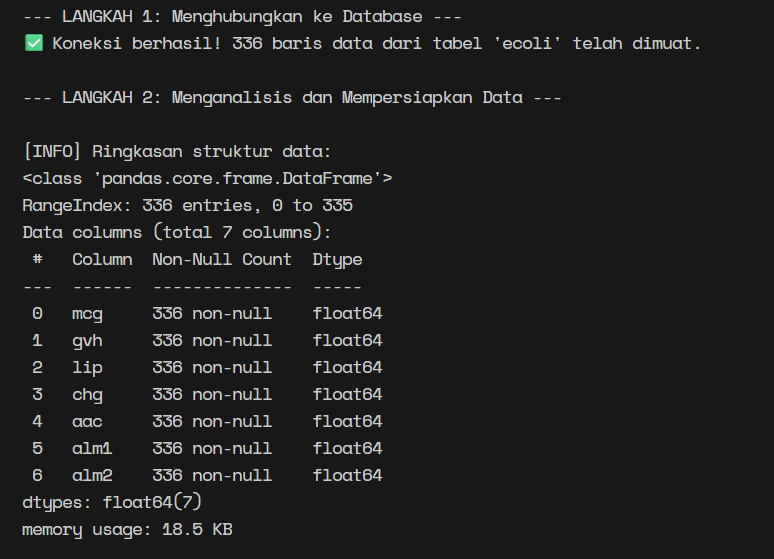

**Hasil analisis**

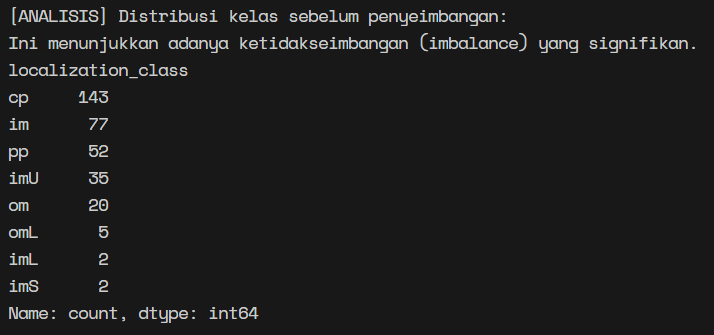

Hasilnya menunjukkan ada ketidakseimbangan yang cukup parah. Kelas mayoritas (cp) memiliki 143 sampel, sedangkan beberapa kelas minoritas (imL, imS) hanya punya 2. Kondisi ini bisa membuat model machine learning cenderung mengabaikan kelas-kelas minoritas tersebut.

Untuk melihatnya secara visual, saya menggunakan PCA (Principal Component Analysis). Karena data kita memiliki 7 fitur (7 dimensi) yang tidak mungkin digambar, PCA membantu merangkum 7 fitur tersebut menjadi 2 komponen utama yang bisa kita plot dalam grafik 2D. Visualisasinya mengonfirmasi bahwa sebaran data memang sangat tidak merata, di mana kelas-kelas minoritas hampir tidak terlihat.

### **2. Visualisasi Data dengan PCA**
Untuk mendapatkan gambaran visual dari ketidakseimbangan ini, saya menggunakan PCA (Principal Component Analysis). Teknik ini mereduksi 7 fitur data menjadi 2 komponen utama, sehingga bisa divisualisasikan dalam plot 2D.

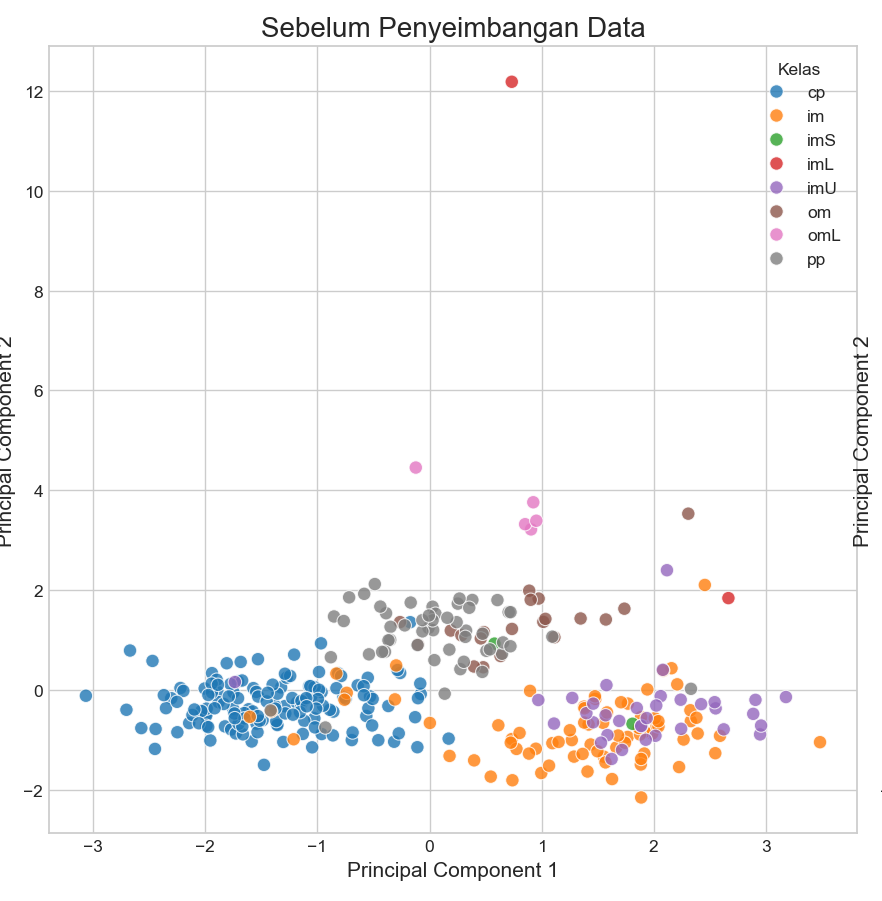

Plot tersebut mengonfirmasi bahwa sebaran data didominasi oleh beberapa kelas mayoritas, sedangkan kelas-kelas minoritas sulit untuk diamati.

### **Langkah 3: Implementasi SMOTE**

Metode pertama yang saya gunakan adalah SMOTE (Synthetic Minority Over-sampling Technique). Tujuannya adalah menyamakan jumlah sampel di setiap kelas.

**Bagaimana Cara Kerja SMOTE?***
SMOTE tidak hanya menduplikasi data yang ada. Cara kerjanya lebih cerdas:
1. Ia memilih sebuah sampel dari kelas minoritas secara acak.
2. Ia mencari beberapa tetangga terdekatnya (dalam kasus ini, saya atur k=1).
3. Ia kemudian membuat titik data sintetis (buatan) baru di sepanjang garis yang menghubungkan sampel asli dengan tetangga yang dipilih.

Proses ini diulang hingga jumlah sampel di kelas minoritas setara dengan kelas mayoritas.

```python
# Menerapkan SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
```

Hasilnya, semua kelas minoritas berhasil di-sampling hingga jumlahnya sama persis dengan kelas mayoritas, yaitu 143 sampel. SMOTE adalah solusi yang efektif dan cepat untuk mencapai keseimbangan kuantitas.

### **Langkah 4: Implementasi ADASYN**
Metode kedua adalah ADASYN (Adaptive Synthetic Sampling). Pendekatan ADASYN sedikit berbeda dan dianggap lebih "pintar".

**Bagaimana Cara Kerja ADASYN?**
ADASYN tidak memperlakukan semua sampel minoritas secara setara. Ia lebih fokus pada sampel yang dianggap "sulit dipelajari".
1. Pertama, ia menghitung seberapa sulit setiap sampel minoritas dengan cara melihat tetangga terdekatnya. Jika sebuah sampel minoritas dikelilingi oleh banyak sampel dari kelas mayoritas, ia dianggap "sulit".
2. Berdasarkan tingkat kesulitan ini, ADASYN menentukan berapa banyak data sintetis yang perlu dibuat untuk setiap sampel. Sampel yang lebih sulit akan mendapatkan porsi pembuatan data yang lebih besar.
3. Proses pembuatan data sintetisnya mirip dengan SMOTE, namun jumlahnya proporsional dengan tingkat kesulitan.

Saat implementasi, saya menemukan satu kendala. ADASYN memerlukan jumlah sampel minimum di setiap kelas untuk bisa bekerja, dan data saya tidak memenuhinya. Solusinya, saya menggunakan RandomOverSampler terlebih dahulu untuk menaikkan jumlah sampel di kelas yang sangat kecil (yang hanya berisi 2 dan 5 data) menjadi 6. Setelah itu, ADASYN baru bisa dijalankan.

```python
# Menerapkan ADASYN dengan pipeline
ros = RandomOverSampler(sampling_strategy={'omL': 6, 'imL': 6, 'imS': 6}, random_state=42)
adasyn = ADASYN(random_state=42)
pipeline = Pipeline([('ros', ros), ('adasyn', adasyn)])
X_adasyn, y_adasyn = pipeline.fit_resample(X, y)
```

Hasil dari ADASYN ini menarik. Berbeda dengan SMOTE, jumlah sampel setelah penyeimbangan tidak seragam. Ada yang 142, 145, bahkan 157. Perbedaan jumlah ini adalah ciri khas ADASYN. Algoritma ini secara adaptif membuat lebih banyak data untuk kelas-kelas yang dianggapnya lebih sulit.

### **Langkah 5: Perbandingan Hasil**
Untuk melihat perbedaan output dengan jelas, saya membuat tabel perbandingan jumlah sampel.

**Tabel Perbandingan Jumlah Sampel:**
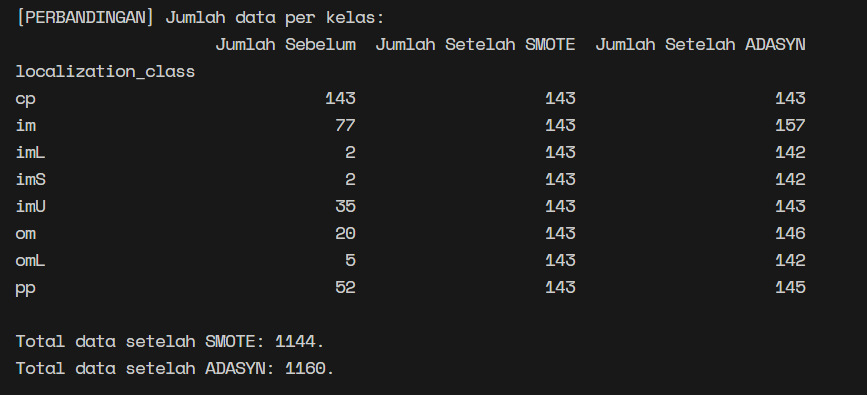

Tabel ini merangkum perbedaan utama antara kedua metode tersebut. Terlihat jelas bagaimana SMOTE menyamaratakan semua kelas, sementara ADASYN memberikan bobot berbeda berdasarkan tingkat kesulitan data.

### **Langkah 6: Visualisasi Perbandingan Akhir**
Terakhir, saya membuat plot perbandingan tiga panel untuk memvisualisasikan hasilnya. Visualisasi ini adalah cara terbaik untuk 'merasakan' dampak dari setiap metode.

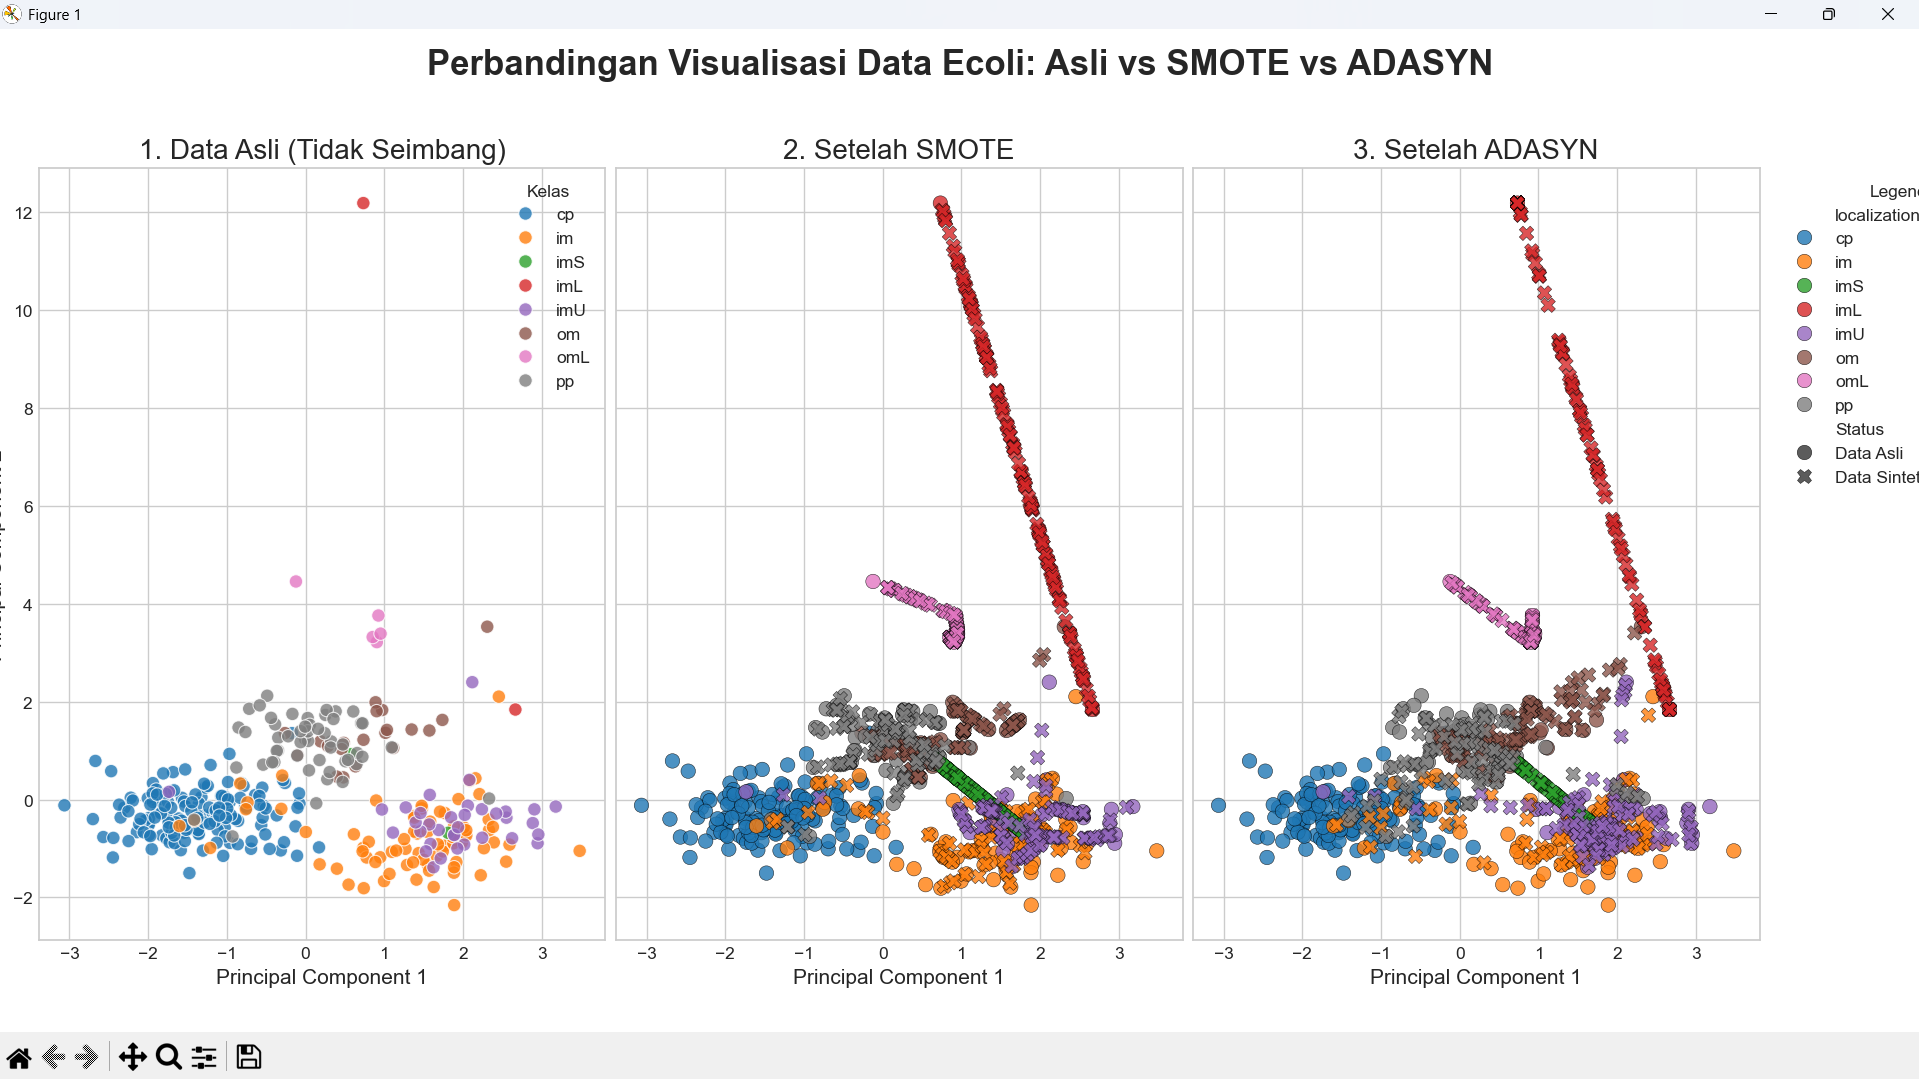

- Plot Kiri (Data Asli): Menunjukkan distribusi data yang tidak seimbang dengan jelas. Area untuk kelas minoritas terlihat sangat kosong.
- Plot Tengah (Setelah SMOTE): Menunjukkan data yang sudah seimbang, di mana data sintetis (ditandai X) tersebar untuk mengisi kekosongan secara merata.
- Plot Kanan (Setelah ADASYN): Menunjukkan data yang juga seimbang, namun sebaran data sintetisnya lebih fokus pada area-area yang dianggap sulit, yaitu perbatasan antara kelas mayoritas dan minoritas.

### **Kesimpulan dan Langkah Selanjutnya**
**Dari perbandingan ini, dapat disimpulkan bahwa:**
- **SMOTE adalah pilihan yang solid dan cepat jika tujuannya adalah untuk mencapai keseimbangan kuantitas secara merata.**
- **ADASYN menawarkan pendekatan yang lebih canggih dengan fokus pada kasus-kasus sulit, yang berpotensi menghasilkan model yang lebih tangguh, meskipun implementasinya mungkin memerlukan penyesuaian seperti yang saya lakukan.**

Langkah selanjutnya dari proyek ini adalah melatih beberapa model klasifikasi (misalnya, Logistic Regression, Random Forest) pada ketiga versi dataset ini (asli, hasil SMOTE, dan hasil ADASYN). Dengan membandingkan metrik performa seperti F1-Score atau AUC-ROC (yang lebih andal untuk data tidak seimbang), kita bisa menentukan secara objektif teknik mana yang memberikan peningkatan performa model terbaik untuk dataset Ecoli ini.

Kode Lengkap
Berikut adalah skrip Python yang saya gunakan untuk seluruh proses analisis dan visualisasi ini.

```python
# Impor library yang dibutuhkan
import pandas as pd
import mysql.connector
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Mengabaikan warning yang mungkin muncul dari imblearn
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use('seaborn-v0_8-whitegrid')
print("--- LANGKAH 1: Menghubungkan ke Database ---")
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'pertemuan5'
}
table_name = 'ecoli'

try:
    conn = mysql.connector.connect(**db_config)
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, conn)
    conn.close()
    print(f"✅ Koneksi berhasil! {len(df)} baris data dari tabel '{table_name}' telah dimuat.")

except mysql.connector.Error as e:
    print(f"❌ Error saat koneksi ke MySQL: {e}")
    exit()

# LANGKAH 2: ANALISIS & PERSIAPAN DATA
print("\n--- LANGKAH 2: Menganalisis dan Mempersiapkan Data ---")
feature_columns = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
target_column = 'localization_class'

X = df[feature_columns]
y = df[target_column]

print("\n[INFO] Ringkasan struktur data:")
X.info()

print("\n[ANALISIS] Distribusi kelas sebelum penyeimbangan:")
print("Ini menunjukkan adanya ketidakseimbangan (imbalance) yang signifikan.")
class_counts_before = y.value_counts()
print(class_counts_before)

# LANGKAH 3: TRANSFORMASI PCA PADA DATA ASLI
print("\n--- LANGKAH 3: Melakukan Transformasi PCA pada Data Asli ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df_original = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df_original[target_column] = y
print("✅ PCA pada data asli selesai. Siap untuk visualisasi.")

# LANGKAH 4: PROSES PENYEIMBANGAN DATA DENGAN ADASYN
print("\n--- LANGKAH 4: Menyeimbangkan Data Menggunakan ADASYN (Pendekatan 2 Langkah) ---")
print("Karena ADASYN gagal pada kelas < 6 sampel, kita lakukan 2 langkah:")
print("1. RandomOverSampler untuk menaikkan kelas minoritas menjadi 6 sampel.")
print("2. ADASYN untuk menyeimbangkan seluruh dataset.")
n_original = len(X)

# Langkah 1: untuk RandomOverSampler
# kelas yang jumlahnya di bawah 6
sampling_strategy_step1 = {
    'omL': 6, # dari 5
    'imL': 6, # dari 2
    'imS': 6  # dari 2
}
for cls in class_counts_before.index:
    if cls not in sampling_strategy_step1:
        sampling_strategy_step1[cls] = class_counts_before[cls]

adasyn = ADASYN(random_state=42)
ros = RandomOverSampler(sampling_strategy=sampling_strategy_step1, random_state=42)

# Gabungkan dalam pipeline
pipeline = Pipeline([('ros', ros), ('adasyn', adasyn)])

# Jalankan proses resampling
X_resampled, y_resampled = pipeline.fit_resample(X, y)

print("✅ Proses ADASYN selesai.")

comparison_df = pd.DataFrame({
    'Jumlah Sebelum': class_counts_before,
    'Jumlah Sesudah': y_resampled.value_counts()
}).fillna(0).astype(int)

print("\n[PERBANDINGAN] Jumlah data per kelas sebelum dan sesudah ADASYN:")
print(comparison_df)
print(f"\nTotal data meningkat dari {n_original} menjadi {len(X_resampled)}.")

# LANGKAH 5: VISUALISASI PERBANDINGAN
print("\n--- LANGKAH 5: Menampilkan Visualisasi Perbandingan ---")
print("Plot akan ditampilkan. Mohon tutup jendela plot untuk mengakhiri skrip.")
X_resampled_scaled = scaler.transform(X_resampled)
X_pca_resampled = pca.transform(X_resampled_scaled)

pca_resampled_df = pd.DataFrame(data=X_pca_resampled, columns=['Principal Component 1', 'Principal Component 2'])
pca_resampled_df[target_column] = y_resampled
status = ['Data Asli'] * n_original + ['Data Sintetis (ADASYN)'] * (len(X_resampled) - n_original)
pca_resampled_df['Status'] = status
fig, axes = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle('Perbandingan Visualisasi Data Ecoli Sebelum dan Sesudah ADASYN', fontsize=20, weight='bold')

# Plot 1: Data Asli (Sebelum)
sns.scatterplot(
    ax=axes[0],
    x='Principal Component 1',
    y='Principal Component 2',
    hue=target_column,
    data=pca_df_original,
    palette='tab10',
    alpha=0.8,
    s=60
)
axes[0].set_title('Sebelum Penyeimbangan Data', fontsize=16)
axes[0].set_xlabel('Principal Component 1', fontsize=12)
axes[0].set_ylabel('Principal Component 2', fontsize=12)
axes[0].legend(title='Kelas')

# Plot 2: Data Seimbang (Sesudah ADASYN)
sns.scatterplot(
    ax=axes[1],
    x='Principal Component 1',
    y='Principal Component 2',
    hue=target_column,
    style='Status',
    data=pca_resampled_df,
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='black',
    linewidth=0.3
)
axes[1].set_title('Setelah Penyeimbangan Data dengan ADASYN', fontsize=16)
axes[1].set_xlabel('Principal Component 1', fontsize=12)
axes[1].set_ylabel('Principal Component 2', fontsize=12)
axes[1].legend(title='Legenda', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n✅ Semua langkah selesai.")
```